In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [8]:
# GMM
for x in samples:
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_lymphocytes', definition='+')
    child_populations.add_population('gmm_lymphocytes_NEG', definition='-')
    pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
    gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                          conf=0.99, transform_x=None, transform_y=None)
    hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_lymphocytes', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [5]:
# dbscan
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'dbscan_lymphocytes' in hc.populations.keys():
        continue
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_lymphocytes', target=(70000, 40000), weight=1)
    gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.1,
                          transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', method='dbscan',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_lymphocytes', plot_output=False)
    hc.save(overwrite=True)
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Saved successfully!


In [7]:
# hdbscan
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'hdbscan_lymphocytes' in hc.populations.keys():
        del hc
        gc.collect()
        continue
    try:
        if 'hdbscan_lymphocytes' in hc.gates.keys():
            hc.gates.pop('hdbscan_lymphocytes')
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
        gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=100, frac=0.01,
                               transform_x=None, transform_y=None)
        hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', method='hdbscan',
                       kwargs=gate_definition, child_populations=child_populations)
        hc.apply('hdbscan_lymphocytes', plot_output=False)
        hc.save(overwrite=True)
    except Exception as e:
        print(f'Failed {x}: {e}')
    del hc
    gc.collect()

[(0, 26785.984426251165), (1, 88865.43277166855)]
Saved successfully!
Saved successfully!
[(0, 78791.23423169795), (1, 24707.75543042522)]
Saved successfully!
[(1, 23206.935428769913), (0, 25065.72085182516)]
Saved successfully!
Saved successfully!
[(0, 16367.206044611885), (1, 41688.90228315046)]
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [10]:
# 2DDens
import gc
for x in samples:
    hc = Gating(exp, x)
    if 'dens2d_lymphocytes' in hc.populations.keys():
        hc.populations.pop('dens2d_lymphocytes')
        hc.populations.pop('dens2d_lymphocytes_NEG')
    if 'dens2d_lymphocytes' in hc.gates.keys():
        hc.gates.pop('dens2d_lymphocytes')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_lymphocytes', definition='--')
    child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
    gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=1000, transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_lymphocytes', plot_output=False)
    hc.save(overwrite=True)
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [13]:
# 2DDens
import gc

for x in samples:
    hc = Gating(exp, x)
    if 'dens2d_liveCD3' in hc.populations.keys():
        hc.populations.pop('dens2d_liveCD3')
    if 'dens2d_liveCD3_NEG' in hc.populations.keys():
        hc.populations.pop('dens2d_liveCD3_NEG')
    if 'dens2d_liveCD3' in hc.gates.keys():
        hc.gates.pop('dens2d_liveCD3')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_liveCD3', definition='--')
    child_populations.add_population('dens2d_liveCD3_NEG', definition=['++', '+-', '-+'])
    gate_definition = dict(x='CD3', y='L/D', kde_bw=0.2)
    hc.create_gate(gate_name='dens2d_liveCD3', parent='lymphocytes', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_liveCD3', plot_output=False)
    hc.save(overwrite=True)
    del hc
    gc.collect()

Saved successfully!
Saved successfully!
Invalid parent; does not exist in current Gating object
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [ ]:
def visualise_manual_ellipse(hc, centroid, width, height, angle, xlim, ylim):
    data = hc.get_population_df('root')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data['FSC-A'], data['SSC-A'], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [ ]:
hc = Gating(exp, 'hc1')
for x in ['manual_lymphocytes', 'manual_lymphocytes_NEG']:
    if x in hc.populations.keys():
        hc.populations.pop(x)
if 'manual_lymphocytes' in hc.gates.keys():
    hc.gates.pop('manual_lymphocytes')

In [ ]:
centroid=(110000, 45000)
width=100000
height=70000
angle=30
visualise_manual_elipse(hc, centroid, width, height, angle, xlim=(0, 250000), ylim=(0,250000))

In [14]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

In [15]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=centroid, width=width, height=height, angle=angle)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

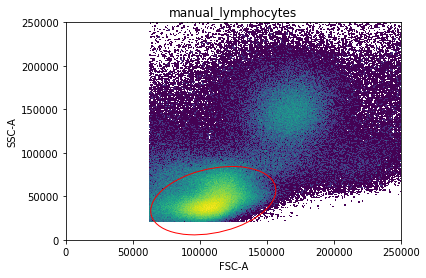

In [16]:
hc.apply('manual_lymphocytes')

In [ ]:
hc.save(overwrite=True)